# Assignment III 
by *Elad Vromen*, *Ido Biran* and *Itay Zohar*

---

## imports

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import re
import nltk 
import seaborn as sns
from  keras.models import Sequential
from keras.layers import Dropout, Conv1D, Flatten, Dense, Embedding
from tensorflow.keras.preprocessing.text import Tokenizer as keras_tokenizer
import numpy as np
from keras.utils import pad_sequences
from sklearn.metrics import accuracy_score
from matplotlib import pyplot as plt

import seaborn as sb



In [2]:
train_df = pd.read_csv('https://github.com/odedovadia/AdvancedMLDLCourse/blob/main/Assignments/Assignment%20III/train.csv?raw=true')
test_df = pd.read_csv('https://github.com/odedovadia/AdvancedMLDLCourse/blob/main/Assignments/Assignment%20III/test.csv?raw=true')

In [3]:
results = {}

## pre-process

In [4]:
train_df

,Dialogue,Character,Episode,Show,Dialogue_length
0,Hey.,joey,Season-07 Episode-13-The One Where Rosita Dies,Friends,1
1,(to Joey) Are you gonna be embarrassed going ...,phoebe,Season-10 Episode-04-The One With The Cake,Friends,13
2,"Me? No no no, you. You're gonna tell him. I'm ...",elaine,S03E22,Seinfeld,14
3,Alright you guys are off to party number one ...,chandler,Season-02 Episode-22-The One With the Two Parties,Friends,56
4,Am I? Or am I so sane that you just blew your ...,kramer,S05E12,Seinfeld,13
...,...,...,...,...,...
70400,Pretty much.,jerry,S05E09,Seinfeld,2
70401,"Oh, well um, not right now. Y'know I’m just g...",phoebe,Season-03 Episode-05-The One With Frank Jr.,Friends,22
70402,"Ooh, I think I wanna trade circles.",phoebe,Season-07 Episode-22-The One With Chandler’s Dad,Friends,7
70403,"Hey, hey, what is this? What's going on here?",jerry,S05E03,Seinfeld,9


In [5]:
train_df.iloc[11][0]

' Forty-five minutes? We have tickets to the Musicman at 8:00.'

In [6]:
train_df.Show.value_counts()

Friends     39092
Seinfeld    31313
Name: Show, dtype: int64

In [7]:
def make_label(df:pd.DataFrame):
    labels = pd.Series([0 if show == 'Seinfeld' else 1 for show in df.Show])
    not_dialoug = train_df.columns[~train_df.columns.isin(['Dialogue'])]
    df = df.drop(not_dialoug, axis=1)
    return labels, df
train_label, train_data = make_label(train_df)
test_label, test_data = make_label(test_df)



In [8]:
train_data.columns

Index(['Dialogue'], dtype='object')

In [9]:
x_train, x_val, y_train, y_val = train_test_split(train_data, train_label, test_size=1/6)

In [10]:
x_train

,Dialogue
232,I've gotta go to the bathroom.
43455,"Oh, who do you think you are? Castanza?"
15955,"Rach, did you proofread these?"
59141,(puzzled) I bought it. (enters lobby)
25220,"Hu hu, ha ha ha."
...,...
40415,"Well, they're not mine!"
64512,"Oh no! (She runs to see.) (Running back, exci..."
65729,"Oh, god! Let us out!"
33711,"What? Come on, you do what you want to do. Do..."


In [11]:
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

### this clean-up method allows us to easly to configure training with or without spacial caharacters removal , and stop words removal. 

In [12]:
pattern = r'[^a-zA-Z0-9\s]'
rm_special = lambda text: re.sub(pattern,'',text)
tokenizer = nltk.tokenize.toktok.ToktokTokenizer()


def remove_stopwords(text):
        global tokenizer
        stopword_list = nltk.corpus.stopwords.words('english')
        tokens = tokenizer.tokenize(text)
        tokens = [token.strip() for token in tokens]
        filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
        filtered_text = ' '.join(filtered_tokens)    
        return filtered_text


def cleanup(df:pd.DataFrame, no_special=True, stop_words=True):
    
    global rm_special, tokenizer
    if (not (no_special or stop_words)):
      print('i did nothing')
      return df
    
    def apply_this(text):
      nonlocal no_special, stop_words
      # removing special characters
      if no_special:
        text = rm_special(text)        
      if stop_words:
        text = remove_stopwords(text)
      return text

    df['Dialogue'] = df['Dialogue'].apply(apply_this)
    return df
    



    


    


In [13]:
x_train = cleanup(x_train)
x_val = cleanup(x_val)

In [14]:
x_train

,Dialogue
232,Ive gotta go bathroom
43455,Oh think Castanza
15955,Rach proofread
59141,puzzled bought enters lobby
25220,Hu hu ha ha ha
...,...
40415,Well theyre mine
64512,Oh runs see Running back excitedly Oh Wow
65729,Oh god Let us
33711,Come want always everything together


### tokenize

In [15]:
token = keras_tokenizer(lower=False)
token.fit_on_texts(x_train['Dialogue'])
total_words = len(token.word_index)+1
print('total words: ', total_words)
x_train_sq = token.texts_to_sequences(x_train['Dialogue'])
x_val_sq = token.texts_to_sequences(x_val['Dialogue'])
x_test_sq = token.texts_to_sequences(test_data['Dialogue'])

total words:  25576


In [16]:


## tokenzie and create sequences
x_train_sq[1]

[1, 14, 12309]

### padding

In [17]:
len_list = [len(d) for d in x_train['Dialogue']]
max(len_list), min(len_list), np.mean(len_list)

(1146, 0, 33.81789671041418)

In [18]:
np.argmax(len_list)

33869

In [19]:
len(x_train['Dialogue'].iloc[48526])

10

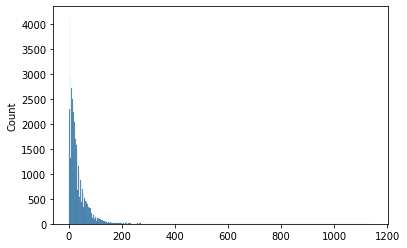

In [20]:
sns.histplot(len_list)

In [21]:
max_words = 150

x_train_sq = pad_sequences(x_train_sq, maxlen=max_words)
x_val_sq = pad_sequences(x_val_sq, maxlen=max_words)
x_test_sq = pad_sequences(x_test_sq, maxlen=max_words)

In [22]:
x_val_sq[25]

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0, 138,   8], dtype=int32)

## training

In [23]:
model = Sequential()
model.add(Embedding(input_dim=total_words, output_dim=32, input_length=max_words))
model.add(Conv1D(8, 3, padding='same', activation='relu'))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 150, 32)           818432    
                                                                 
 conv1d (Conv1D)             (None, 150, 8)            776       
                                                                 
 flatten (Flatten)           (None, 1200)              0         
                                                                 
 dense (Dense)               (None, 64)                76864     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 896,137
Trainable params: 896,137
Non-trai

In [24]:
model.fit(x_train_sq, y_train, validation_data=(x_val_sq, y_val), epochs=5, batch_size=64)

Epoch 1/5
917/917 [==============================] - 14s 5ms/step - loss: 0.5509 - accuracy: 0.6827 - val_loss: 0.4868 - val_accuracy: 0.7336
Epoch 2/5
917/917 [==============================] - 5s 5ms/step - loss: 0.4159 - accuracy: 0.7863 - val_loss: 0.4971 - val_accuracy: 0.7363
Epoch 3/5
917/917 [==============================] - 5s 6ms/step - loss: 0.3373 - accuracy: 0.8308 - val_loss: 0.5303 - val_accuracy: 0.7398
Epoch 4/5
917/917 [==============================] - 5s 5ms/step - loss: 0.2848 - accuracy: 0.8557 - val_loss: 0.5903 - val_accuracy: 0.7328
Epoch 5/5
917/917 [==============================] - 5s 5ms/step - loss: 0.2477 - accuracy: 0.8740 - val_loss: 0.6791 - val_accuracy: 0.7291


## results

In [25]:
model.evaluate(x_test_sq, test_label)

133/133 [==============================] - 0s 3ms/step - loss: 0.6839 - accuracy: 0.8141


[0.6839265823364258, 0.8141342997550964]

In [26]:
results['train'] = 0.7234
results['opt'] = 'adam'
results['loss'] = 'binary_crossentropy'
results['params'] = '897,961'
results['epochs'] = 5
results['layers'] = 6
results['regulars'] = ['dropout']





## accuracy by characther

In [27]:
test_preds = np.round(model.predict(x_test_sq))

133/133 [==============================] - 0s 2ms/step


In [28]:
test_df

,Dialogue,Character,Episode,Show,Dialogue_length
0,"Oh my God, that's great! I'm smart!! No, no, ...",joey,Season-10 Episode-05-The One Where Rachel's Si...,Friends,30
1,"Listen, I’m sure that dad doesn’t care. He pr...",monica,Season-07 Episode-03-The One With Phoebe’s Coo...,Friends,20
2,Well I am. Couldn't you try to go through some...,george,S09E16,Seinfeld,18
3,Yes I am. We had a verbal contract. If we can'...,kramer,S07E13,Seinfeld,20
4,"Um, I straightened out your shower curtain so...",monica,Season-02 Episode-18-The One Where Dr. Remore ...,Friends,17
...,...,...,...,...,...
4240,"I’d say, come again. No-no, wait I-I-I know t...",joey,Season-07 Episode-03-The One With Phoebe’s Coo...,Friends,15
4241,"Okay. (they both look into the camera, and Ro...",rachel,Season-10 Episode-04-The One With The Cake,Friends,22
4242,All right I've been feeling incredibly guilty...,ross,Season-08 Episode-19-The One With Joey’s Inter...,Friends,34
4243,"(getting up to leave) Well, the people have sp...",kramer,S09E15,Seinfeld,21


### make sure index is kept 
as we can see, this would yeild the same sentance, only with cleanups (stopwords/spacial chars)

In [29]:
j = test_df[test_df.Character == 'joey']

In [30]:
j[j.index == 28]

,Dialogue,Character,Episode,Show,Dialogue_length
28,"All right, now you know that the ATM will onl...",joey,Season-06 Episode-19-The One With Joey’s Fridge,Friends,26


In [31]:
test_data.iloc[28]

Dialogue     All right, now you know that the ATM will onl...
Name: 28, dtype: object

In [32]:
x_test_sq[28]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    9,    3, 4195,
        140,   57, 3285,   38,   57,  307,  481], d

In [33]:
token.sequences_to_texts(x_test_sq)[28]

'right know ATM lets take 300 time take check hundred'

In [34]:
all_characters = test_df.Character.unique()
scores = {}
general_accuracy = accuracy_score(test_label, test_preds)

for character in all_characters:
  # get only lines of this character
  current_df = test_df[test_df.Character == character]
  # get only predictions of this character
  indexes = test_df[test_df.Character == character].index
  current_pred = test_preds[indexes]
  current_labels = test_label[indexes]
  scores[character] = accuracy_score(current_labels, current_pred)


In [35]:
results['test'] = general_accuracy

In [36]:
scores = pd.Series(scores)
scores

joey        0.834746
monica      0.866492
george      0.770042
kramer      0.743243
rachel      0.852814
ross        0.835789
phoebe      0.850254
jerry       0.793867
chandler    0.836983
elaine      0.719178
dtype: float64

In [37]:

# just a helper method for showing exact values in the plot
def show_values(axs, orient="v", space=.001):
    def _single(ax):
        if orient == "v":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height() + (p.get_height()*0.01)
                value = round(p.get_height(), 3)
                ax.text(_x, _y, value, ha="center") 
        elif orient == "h":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() + float(space)
                _y = p.get_y() + p.get_height() - (p.get_height()*0.5)
                value = '{:.1f}'.format(p.get_width())
                ax.text(_x, _y, value, ha="left")

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _single(ax)
    else:
        _single(axs)

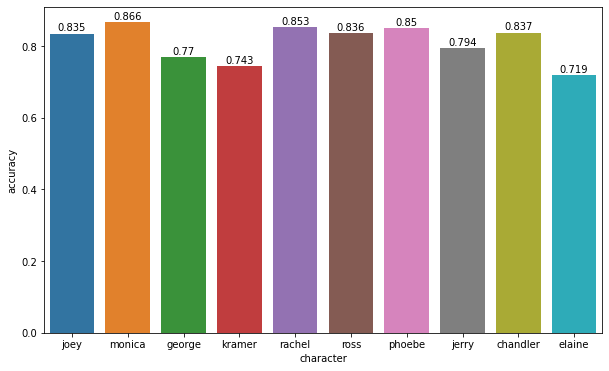

In [38]:
plt.figure(figsize=(10,6))

bars = sb.barplot(x=scores.index, y=scores, )
# for bar, score in zip(bars, scores): bar.set_label(score)
show_values(bars)
bars.set_xlabel('character')
bars.set_ylabel('accuracy')

pass

## results

In [42]:
import pandas as pd

submission = {}
submission['Test score (Accuracy)'] =  results['test']
submission['Train score (Accuracy)'] = results['train']
submission['Number of trainable parameters'] = results['params']
submission['Number of layers'] = results['layers']
submission['Regularization methods'] = results['regulars']
submission['Number of epochs'] = results['epochs']
submission['Loss function'] = results['loss']
submission['Optimizer'] = results['opt']

df = pd.DataFrame(submission)
df
  

,Test score (Accuracy),Train score (Accuracy),Number of trainable parameters,Number of layers,Regularization methods,Number of epochs,Loss function,Optimizer
0,0.814134,0.7234,"897,961",6,dropout,5,binary_crossentropy,adam


In [43]:
import os
df.to_csv(os.path.join(os.getcwd(), 'results.csv'))